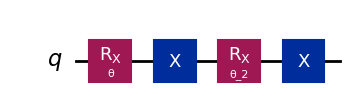

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from gymnasium.spaces import Box
from rl_qoc import (
    CustomPPO,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
    GateTargetConfig,
    QEnvConfig,
    ExecutionConfig,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig

θ = Parameter("θ")
θ_2 = Parameter("θ_2")
qc = QuantumCircuit(1)
qc.rx(θ, 0)
qc.x(0)
qc.rx(θ_2, 0)
qc.x(0)

qc.draw("mpl")

In [2]:
θ_val = 2 * np.pi * np.random.rand()

In [3]:
θ_val

2.7331117223769033

In [4]:
from qiskit_aer.noise import NoiseModel, coherent_unitary_error
from qiskit.circuit.library import RXGate
from qiskit_aer import AerSimulator

γ = 0.2
noisy_unitary = RXGate(γ * θ_val).to_matrix()
noise_model = NoiseModel(basis_gates=["h", "rx", "rz", "t", "s", "sdg", "tdg", "u", "x", "z"])
noise_model.add_all_qubit_quantum_error(coherent_unitary_error(noisy_unitary), "rx")

In [5]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2

backend = GenericBackendV2(
    1,
    ["h", "rx", "rz", "t", "s", "sdg", "tdg", "u", "reset", "x", "z", "sx"],
    calibrate_instructions=True,
    control_flow=True,
)
backend = AerSimulator.from_backend(backend, noise_model=noise_model)

In [6]:
# Define target gate
target = GateTargetConfig(physical_qubits=[0], gate="x")

In [7]:
print(backend.target)

Target: Generic Target with 1 qubits
Number of qubits: 1
Instructions:
	h
		(0,):
			Duration: 4.8618e-08 sec.
			Error Rate: 9.06716e-05
			With pulse schedule calibration
	rx
		(0,):
			Duration: 5.8608e-08 sec.
			Error Rate: 9.39511e-05
			With pulse schedule calibration
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
			With pulse schedule calibration
	t
		(0,):
			Duration: 4.884e-08 sec.
			Error Rate: 9.37427e-05
			With pulse schedule calibration
	s
		(0,):
			Duration: 5.4168e-08 sec.
			Error Rate: 9.29377e-05
			With pulse schedule calibration
	sdg
		(0,):
			Duration: 4.329e-08 sec.
			Error Rate: 9.4843e-05
			With pulse schedule calibration
	tdg
		(0,):
			Duration: 5.772e-08 sec.
			Error Rate: 9.72758e-05
			With pulse schedule calibration
	u
		(0,):
			Duration: 4.0626e-08 sec.
			Error Rate: 9.39822e-05
			With pulse schedule calibration
	reset
		(0,):
	x
		(0,):
			Duration: 3.5298e-08 sec.
			Error Rate: 9.24715e-05
			With pulse schedule calibration
	z
		(0,):
		

In [8]:
# Define parametrized circuit

from qiskit.circuit.library.standard_gates import RXGate


def apply_parametrized_circuit(qc: QuantumCircuit, params, q_reg, **kwargs):
    my_qc = qc.copy_empty_like(name="x_cal")
    optimal_params = [np.pi]
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]
    # my_qc.u(*new_params, -np.pi / 2, np.pi / 2, q_reg[0])
    my_qc.rz(np.pi / 2, q_reg[0])
    my_qc.sx(q_reg[0])
    my_qc.rz(np.pi + new_params[0], q_reg[0])
    my_qc.sx(q_reg[0])
    my_qc.rz(5 * np.pi / 2, q_reg[0])

    qc.append(my_qc.to_gate(label=my_qc.name), q_reg)


qiskit_config = QiskitConfig(
    apply_parametrized_circuit,
    backend,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)

In [9]:
# Define the quantum environment
action_space = Box(low=-np.pi, high=np.pi, shape=(1,), dtype=np.float32)
env_metadata = {"γ": γ, "θ": θ_val}
training_config = QEnvConfig(
    target=target,
    backend_config=qiskit_config,
    reward="cafe",
    execution_config=ExecutionConfig(
        batch_size=32, sampling_paulis=100, n_shots=100, n_reps=[3, 5, 7]
    ),
    action_space=action_space,
    env_metadata=env_metadata,
)

In [10]:
from gate_level.spillover_noise_use_case.generic_spillover.single_qubit_arbitrary_angle_env import (
    ArbitraryAngleCoherentEnv,
)

# q_env = ContextAwareQuantumEnvironment(
#     training_config, circuit_context=qc.assign_parameters({θ: θ_val})
# )
q_env = ArbitraryAngleCoherentEnv(training_config, qc, γ)
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [11]:
q_env.reset()


 Number of repetitions: 3
Sampled angles:  [3.51694901 3.5678236 ]


(array([3.51694901, 3.5678236 ]), {})

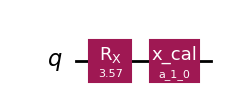

In [12]:
q_env.circuits[1].draw("mpl")

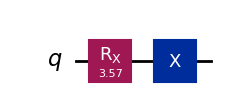

In [13]:
q_env.baseline_circuits[1].draw("mpl")

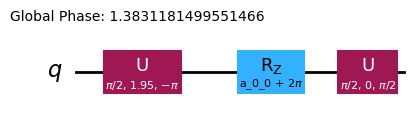

In [14]:
from qiskit import transpile

transpile(q_env.circuits[0], basis_gates=["ry", "rz", "sx", "rx", "u"]).draw("mpl")

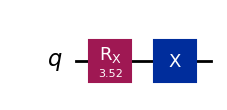

In [15]:
q_env.target.target_circuit.draw("mpl")

In [16]:
q_env.simulate_circuit(q_env.circuits[0], np.array([[0.0]]), update_env_history=False)

[0.6750773806477031]

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.6750773806477031
Reward (avg): 0.67475 Std: 0.0
Number of repetitions: 2
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.6750773806477031
Reward (avg): 0.3705 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.6750773806477031
Reward (avg): 0.5225 Std: 0.0
Number of repetitions: 4
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.6750773806477031
Reward (avg): 0.7355 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.6750773806477031
Reward (avg): 0.68125 Std: 0.0
Number of repetitions: 6
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.6750773806477031
Reward (avg): 0.4540000000

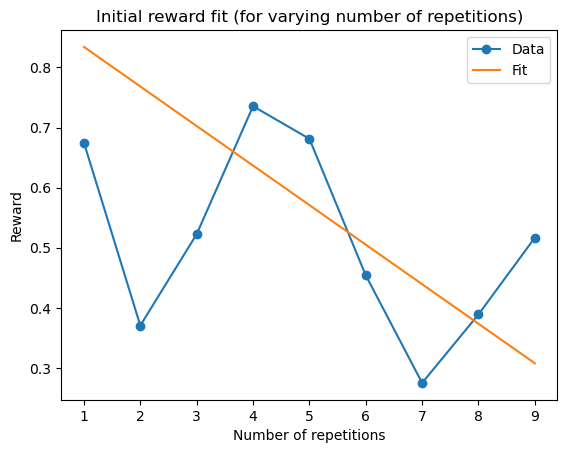

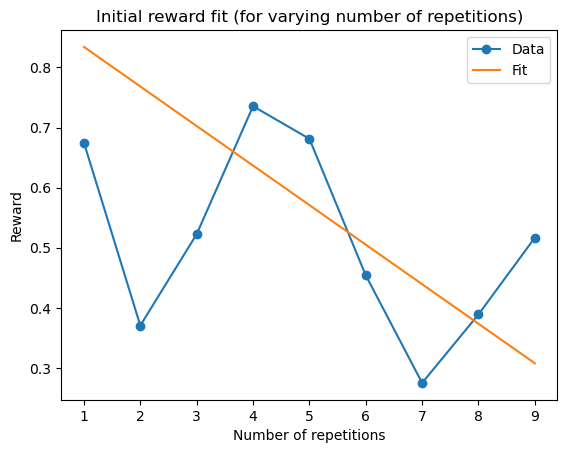

In [17]:
q_env.initial_reward_fit(
    0.0 * np.ones((1, 1)),
    execution_config=ExecutionConfig(
        batch_size=1, sampling_paulis=1000, n_shots=1000, n_reps=list(range(1, 10))
    ),
    update_fit_params=False,
)

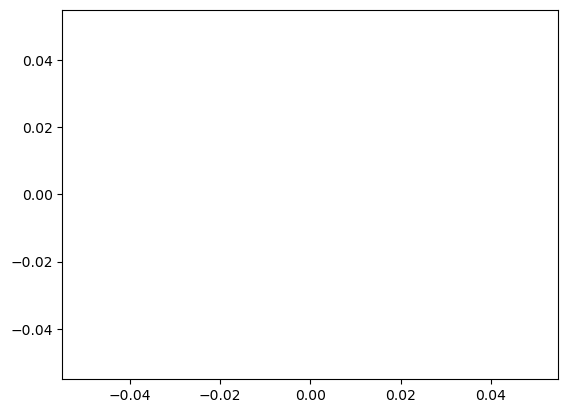

In [18]:
import matplotlib.pyplot as plt

plt.plot(q_env.avg_fidelity_history_nreps)

Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7992464735134485
Reward (avg): 0.7697499999999999 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7992464735134485
Reward (avg): 0.37725 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7992464735134485
Reward (avg): 0.27075 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7992464735134485
Reward (avg): 0.5975 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7992464735134485
Reward (avg): 0.95825 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7992464735134485
Reward (avg): 0.915 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.7992464735134485
Reward (avg): 0.514 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelit

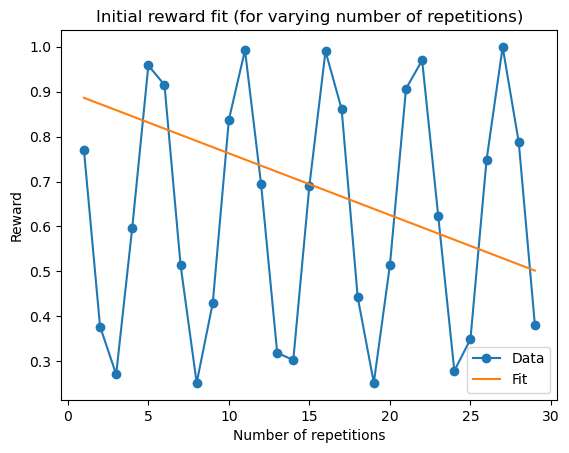

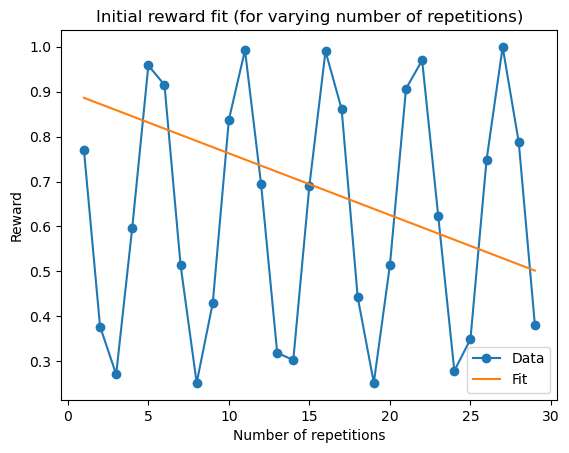

In [21]:
q_env.initial_reward_fit(
    np.zeros((1, 1)),
    execution_config=ExecutionConfig(
        batch_size=1,
        sampling_paulis=100,
        n_shots=1000,
        n_reps=list(range(1, 30)),
    ),
    reward_method="cafe",
    update_fit_params=False,
)

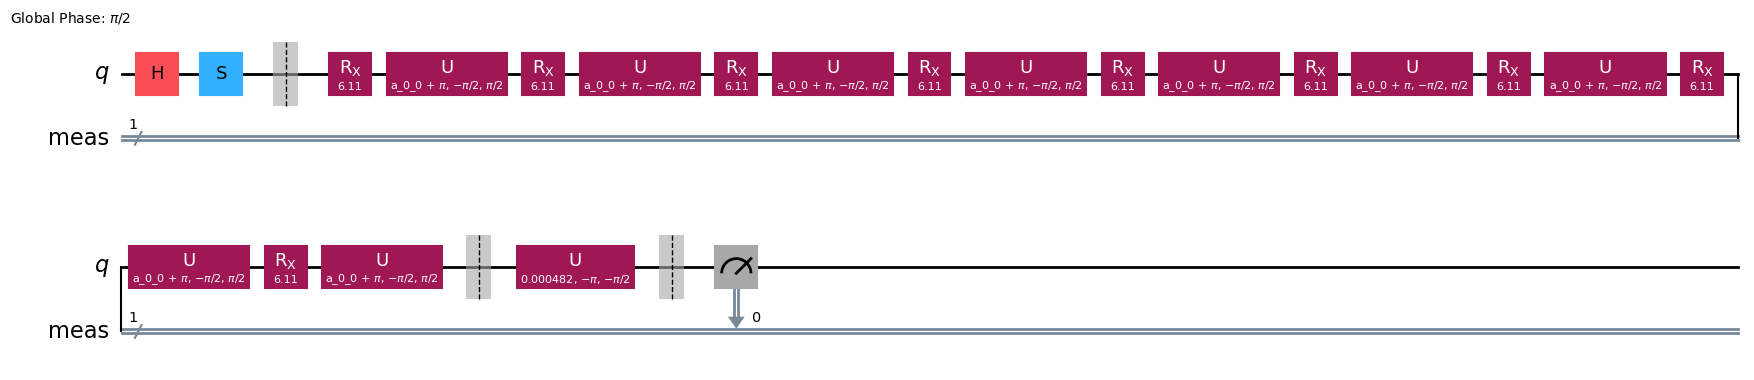

In [73]:
q_env.pubs[3].circuit.draw("mpl")

In [77]:
q_env.pubs[4].observables

ObservablesArray({'Y': 0.534162502924308, 'Z': 1.4209348572348384}, shape=())

In [38]:
from rl_qoc.agent import PPOConfig

ppo_config = PPOConfig.from_yaml("agent_config.yaml")

In [39]:
from rl_qoc.agent import TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(ppo_config, rescaled_env, save_data=False)

In [40]:
total_updates = 500
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

run_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

In [41]:
print(q_env.backend.target)

Target
Number of qubits: 30
Instructions:
	set_density_matrix
	save_expval_var
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
		(6,)
		(7,)
		(8,)
		(9,)
		(10,)
		(11,)
		(12,)
		(13,)
		(14,)
		(15,)
		(16,)
		(17,)
		(18,)
		(19,)
		(20,)
		(21,)
		(22,)
		(23,)
		(24,)
		(25,)
		(26,)
		(27,)
		(28,)
		(29,)
	set_superop
	save_clifford
	u
	save_amplitudes_sq
	save_probabilities
	set_matrix_product_state
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
		(6,)
		(7,)
		(8,)
		(9,)
		(10,)
		(11,)
		(12,)
		(13,)
		(14,)
		(15,)
		(16,)
		(17,)
		(18,)
		(19,)
		(20,)
		(21,)
		(22,)
		(23,)
		(24,)
		(25,)
		(26,)
		(27,)
		(28,)
		(29,)
	superop
	save_expval
	h
	sdg
	t
	if_else
	save_superop
	continue_loop
	save_density_matrix
	set_statevector
	save_amplitudes
	reset
	qerror_loc
	s
	save_statevector
	save_state
	save_unitary
	roerror
	break_loop
	rz
	tdg
	save_matrix_product_state
	quantum_channel
	kraus
	while_loop
	z
	x
	rx
	set_unitary
	save_stabilizer
	save_statevector_dict


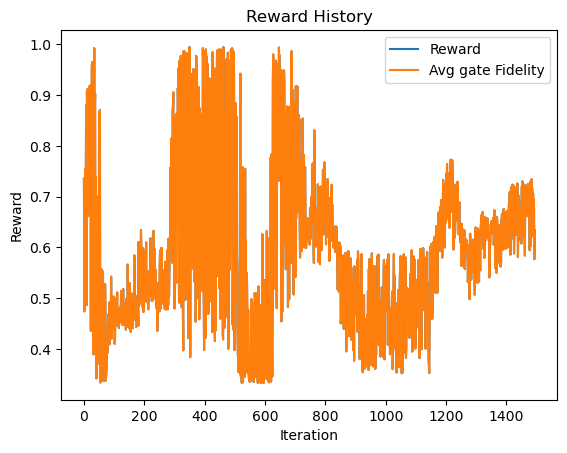

Sampled angles:  [0.25045719]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.6850240888651897
Sampled angles:  [1.67423853]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.7440804743412383


{'avg_reward': [0.7352056419344253,
  0.47422312328897054,
  0.6067875863690921,
  0.6814479169692254,
  0.754321887428358,
  0.5719551919910695,
  0.7035173694694774,
  0.8526853600474581,
  0.8809311201560162,
  0.48645964212018633,
  0.9078919819872497,
  0.8111996837877886,
  0.9116078922523672,
  0.7637486164529004,
  0.6615529054864244,
  0.8278953630329025,
  0.7168678342537218,
  0.8001439434111175,
  0.91664788938698,
  0.7621609517806335,
  0.7806230606883664,
  0.8762670078747976,
  0.9196986377347605,
  0.4357022685904347,
  0.8515723081270852,
  0.6334299411204752,
  0.9559810728193092,
  0.9648048220623736,
  0.948478687511776,
  0.7552270935159189,
  0.9559701674480152,
  0.4008070949767186,
  0.38970194814689063,
  0.6316358025290023,
  0.9921339514806863,
  0.4253330425482027,
  0.8658655077568258,
  0.9025114879165314,
  0.4227681951374657,
  0.7385473739027437,
  0.6959865424002702,
  0.3423659501788725,
  0.34624893285231945,
  0.6955497949018576,
  0.53230309586281

<Figure size 640x480 with 0 Axes>

In [44]:
ppo_agent.train(run_config, train_settings)

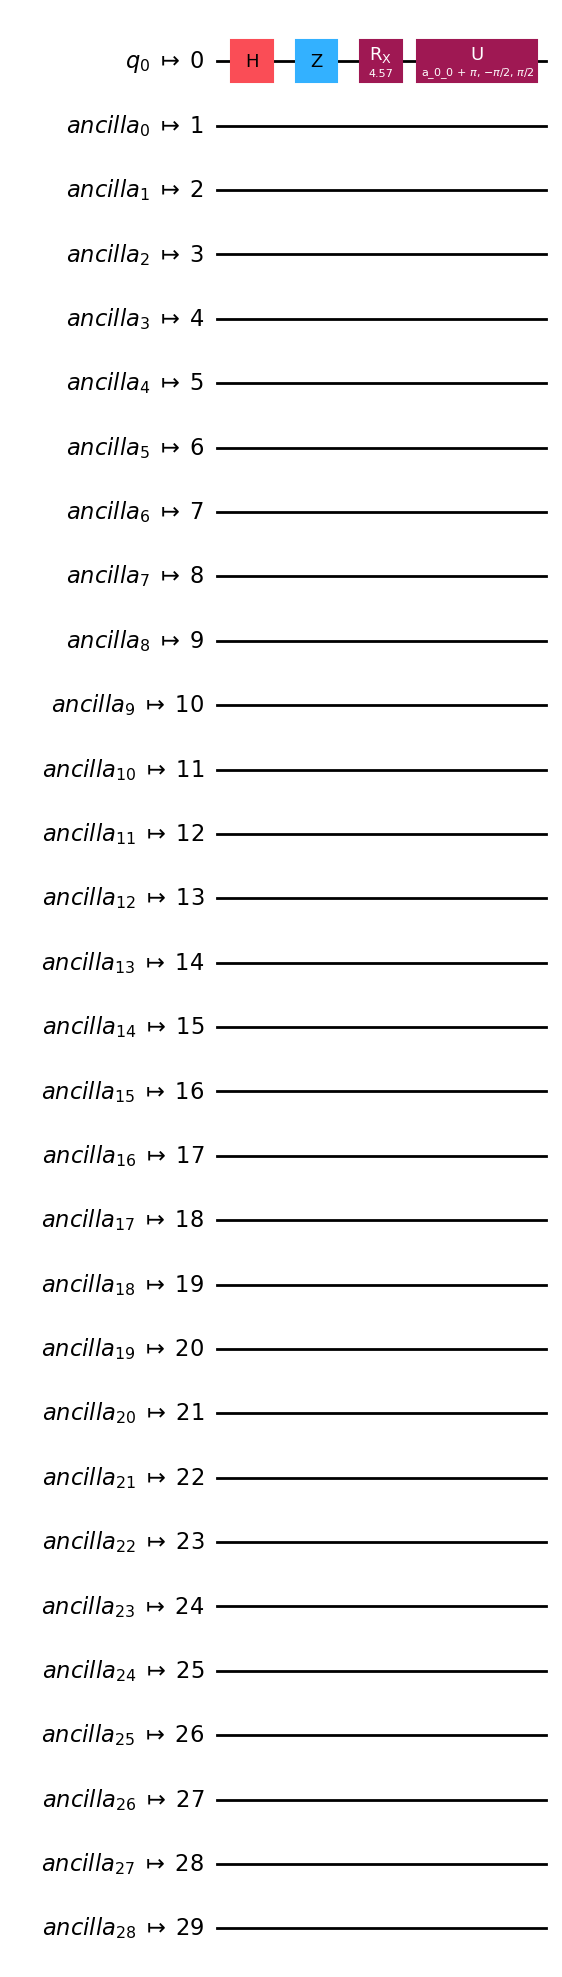

In [27]:
q_env.pubs[0].circuit.draw("mpl")

In [29]:
from torch import Tensor
from gate_level.spillover_noise_use_case.generic_spillover.single_qubit_arbitrary_angle_env import (
    noisy_backend,
)

fidelity_history = []
baseline_history = []
n_angles = 1000
phi_array = np.zeros((n_angles, len(q_env.circuit_parameters)))
for i in range(n_angles):
    phi = np.random.uniform(0, 2 * np.pi, size=len(q_env.circuit_parameters))
    phi_array[i, :] = phi
    mu, sigma, critic = ppo_agent.agent(Tensor(phi))
    print("Mu: ", mu.detach().numpy())
    print("Sigma: ", sigma.detach().numpy())
    param_dict = {q_env.circuit_parameters[i].name: phi[i] for i in range(len(phi))}
    circuit = q_env.unbound_circuit_context.assign_parameters(param_dict)
    backend = noisy_backend(circuit, γ)
    q_env.set_circuit_context(None, backend=backend, **param_dict)
    agent_fid = q_env.simulate_circuit(
        q_env.circuits[0].copy(),
        np.expand_dims(mu.detach().numpy(), 0),
        update_env_history=False,
    )
    fidelity_history.append(agent_fid)
    baseline_fid = q_env.simulate_circuit(
        q_env.circuits[0].copy(), np.zeros((1, 7)), update_env_history=False
    )
    baseline_history.append(baseline_fid)

Mu:  [-0.136985]
Sigma:  [0.02491472]
Mu:  [-0.13320927]
Sigma:  [0.02411214]
Mu:  [-0.14897978]
Sigma:  [0.0243938]
Mu:  [-0.12934613]
Sigma:  [0.02458562]
Mu:  [-0.14695066]
Sigma:  [0.02491043]
Mu:  [-0.15470804]
Sigma:  [0.0264302]
Mu:  [-0.13923949]
Sigma:  [0.02493534]
Mu:  [-0.13999254]
Sigma:  [0.02493915]
Mu:  [-0.14462018]
Sigma:  [0.02493277]
Mu:  [-0.13584071]
Sigma:  [0.0240231]
Mu:  [-0.14982344]
Sigma:  [0.02486267]
Mu:  [-0.13000552]
Sigma:  [0.02467648]
Mu:  [-0.12920637]
Sigma:  [0.02453414]
Mu:  [-0.14093979]
Sigma:  [0.02494192]
Mu:  [-0.15248735]
Sigma:  [0.02508726]
Mu:  [-0.12949836]
Sigma:  [0.0243995]
Mu:  [-0.13697998]
Sigma:  [0.02399908]
Mu:  [-0.12934446]
Sigma:  [0.02443258]
Mu:  [-0.12967177]
Sigma:  [0.02464013]
Mu:  [-0.1420861]
Sigma:  [0.02494243]
Mu:  [-0.13664411]
Sigma:  [0.02491026]
Mu:  [-0.14757282]
Sigma:  [0.02490213]
Mu:  [-0.13223818]
Sigma:  [0.02480558]
Mu:  [-0.14079106]
Sigma:  [0.02494163]
Mu:  [-0.14152206]
Sigma:  [0.02494257]
Mu:  [-

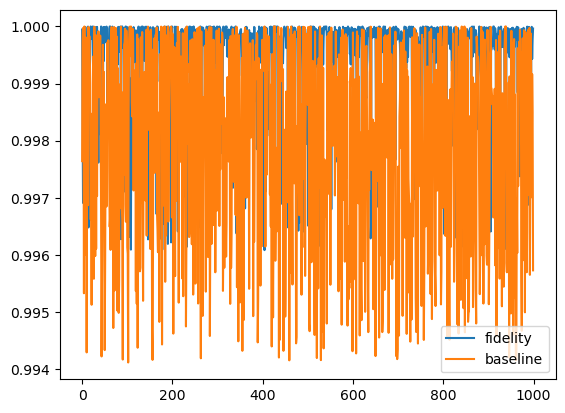

In [30]:
plt.plot(fidelity_history, label="fidelity")
plt.plot(baseline_history, label="baseline")
plt.legend()

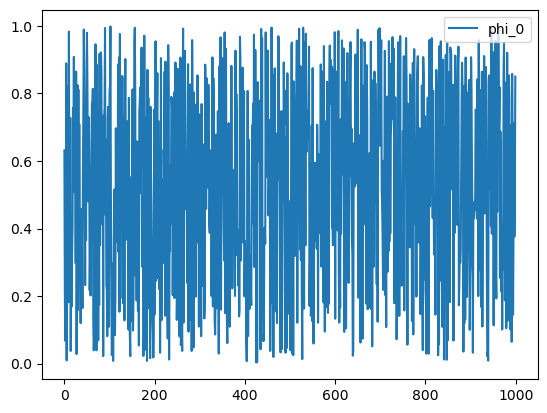

In [31]:
for i in range(len(q_env.circuit_parameters)):
    plt.plot(phi_array[:, i] / (2 * np.pi), label=f"phi_{i}")

plt.legend()

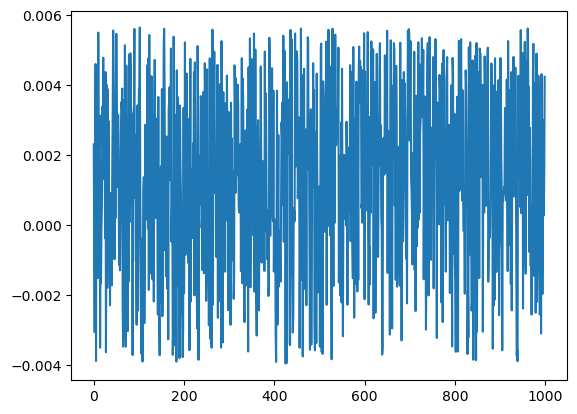

In [32]:
plt.plot(np.array(fidelity_history) - np.array(baseline_history))

In [33]:
print(
    "Percentage of under performance",
    len(np.where(np.array(fidelity_history) - np.array(baseline_history) < 0)[0]) * 100 / n_angles,
    "%",
)

Percentage of under performance 31.3 %


In [27]:
from qiskit.qasm3 import dumps as qasm_dumps

print(qasm_dumps(q_env.pubs[0].circuit))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] a_0_0;
input float[64] a_0_1;
input float[64] a_0_2;
h $0;
U(0, 0, pi) $0;
for _ in [0:8] {
  rx(6.081253023718493) $0;
  U(a_0_0 + pi, a_0_1, a_0_2 + pi) $0;
}



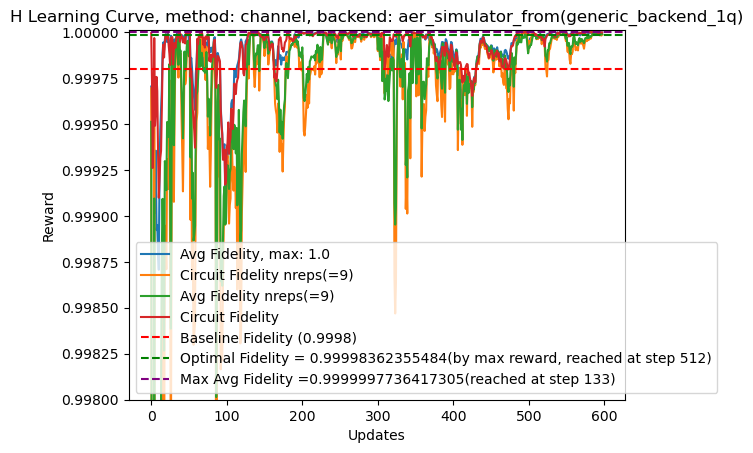

In [115]:
# Plotting the learning curve
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)
baseline_fidelity = np.round(
    q_env.simulate_circuit(q_env.circuits[0], np.zeros((1, 3)), update_env_history=False),
    4,
)[0]

plot_reward = False
plot_fidelity = True
plot_circuit_fidelity = True
plot_fidelity_nreps = True
plot_circuit_fidelity_nreps = True

if plot_reward:
    plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
if plot_fidelity:
    plt.plot(
        q_env.fidelity_history,
        label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
    )
if plot_circuit_fidelity_nreps:
    plt.plot(
        q_env.circuit_fidelity_history_nreps,
        label=f"Circuit Fidelity nreps(={q_env.n_reps})",
    )
if plot_fidelity_nreps:
    plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
if plot_circuit_fidelity:
    plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity = {q_env.fidelity_history[arg_max_mean]}(by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity ={np.max(q_env.fidelity_history)}(reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env.config.backend.name if q_env.config.backend is not None else 'No backend'}"
)
plt.ylim(0.998, 1.00001)
plt.legend()

In [116]:
q_env.optimal_action

array([ 0.00083911, -0.04055472, -0.00375056], dtype=float32)

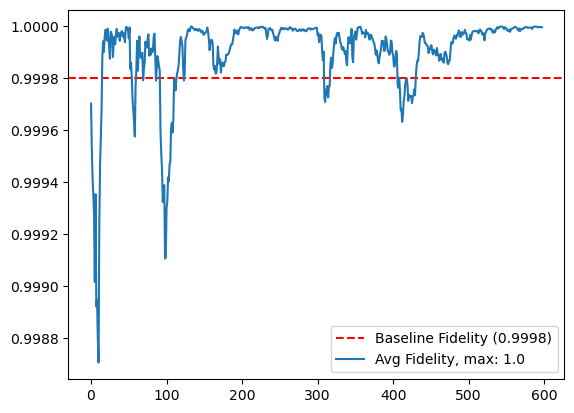

In [117]:
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.plot(
    q_env.fidelity_history,
    label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
)
plt.legend()

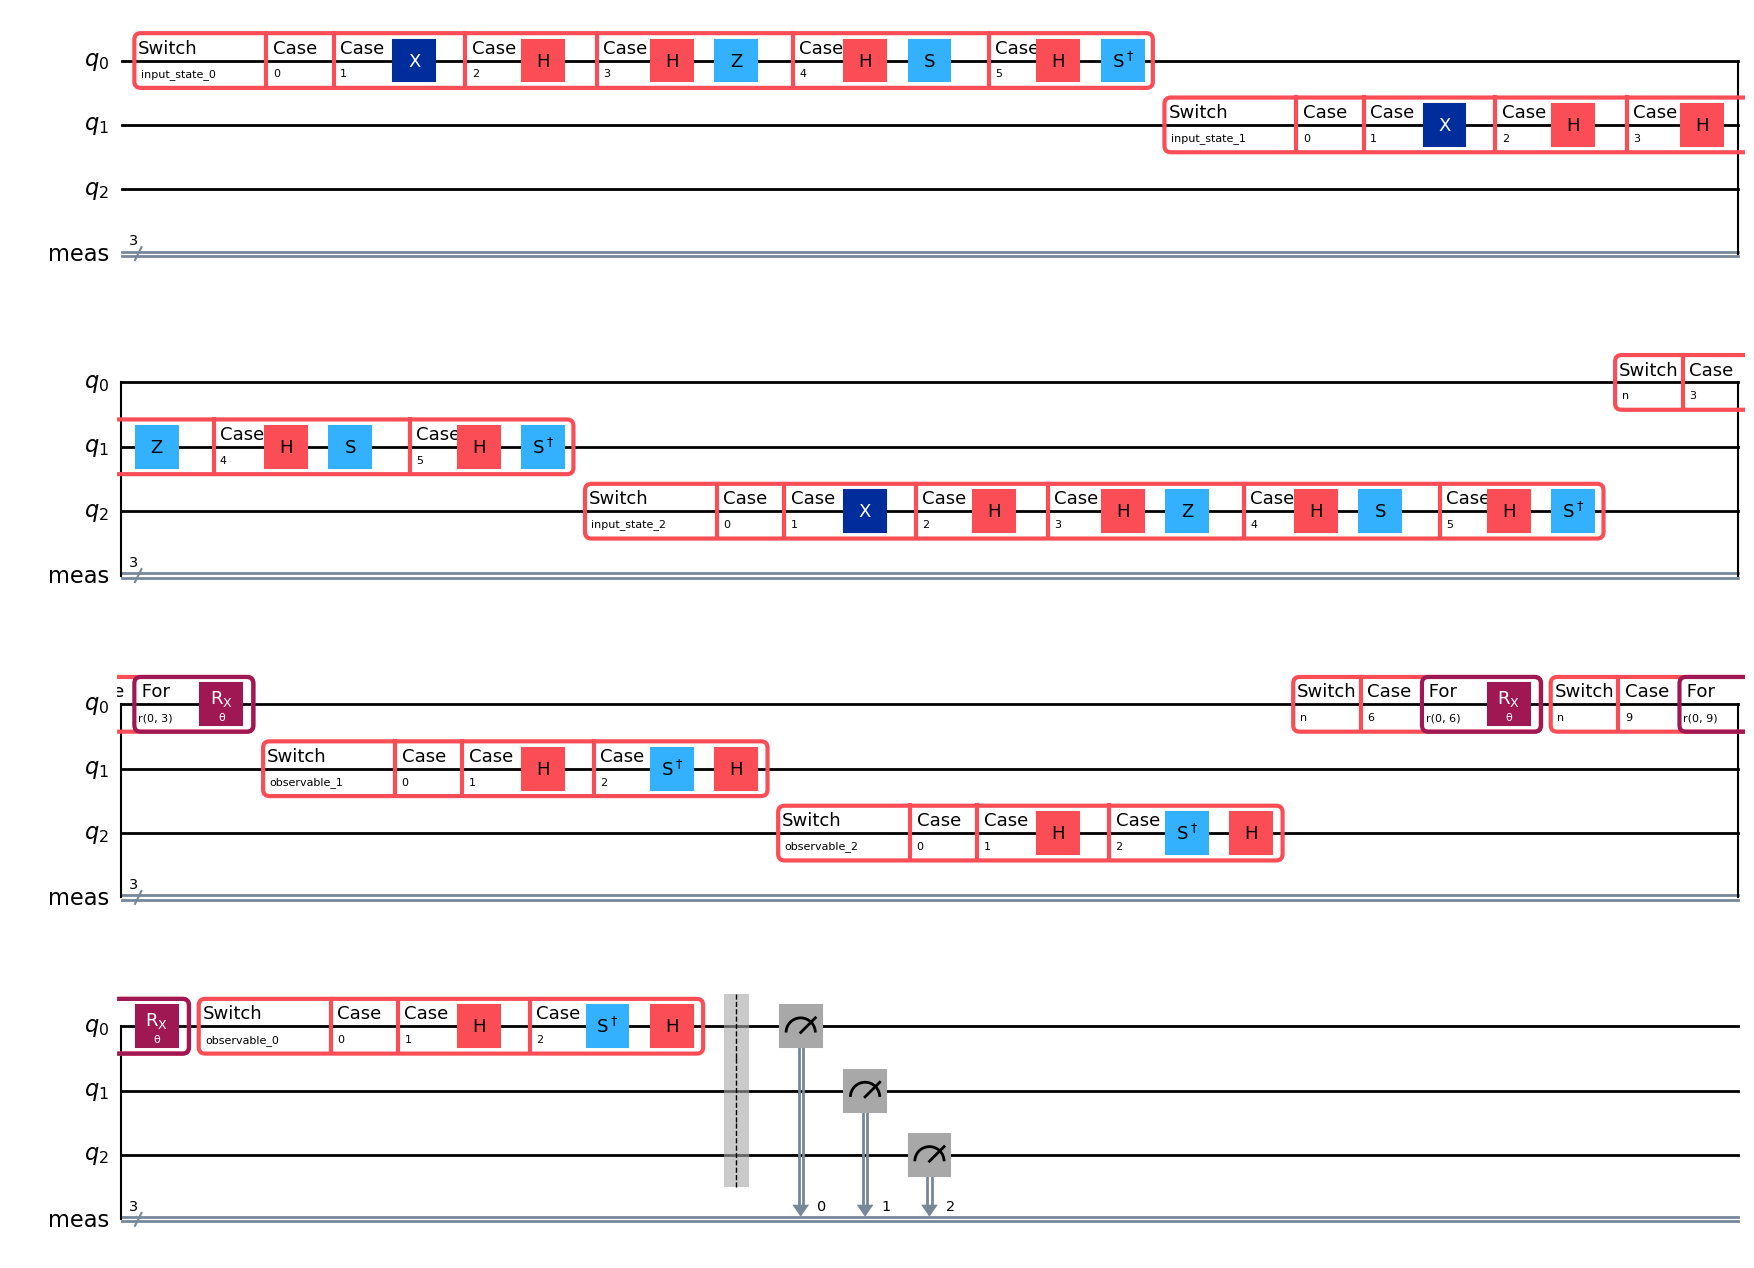

In [37]:
from qiskit.circuit import QuantumCircuit, ClassicalRegister, QuantumRegister, Parameter
from qiskit.circuit.classical.types import Uint, Bool
from qiskit.primitives import StatevectorSampler
from qiskit_aer.primitives import SamplerV2
from qiskit_experiments.library.tomography.basis import (
    Pauli6PreparationBasis,
    PauliMeasurementBasis,
)
import numpy as np

num_qubits = 3
q = QuantumRegister(num_qubits, "q")
qc = QuantumCircuit(q)
θ = Parameter("θ")
input_state = [qc.add_input(f"input_state_{i}", Uint(8)) for i in range(num_qubits)]
observable = [qc.add_input(f"observable_{i}", Uint(8)) for i in range(num_qubits)]
n = qc.add_input("n", Uint(8))
n_reps = [3, 6, 9]
for q_idx, qubit in enumerate(q):
    with qc.switch(input_state[q_idx]) as case:
        for i in range(6):
            with case(i):
                qc.compose(
                    Pauli6PreparationBasis().circuit([i]).decompose(),
                    [qubit],
                    inplace=True,
                )

if len(n_reps) == 1:
    n_ = n_reps[0]
    with qc.for_loop(range(n_)):
        qc.rx(θ, q[0])
else:
    for n_ in n_reps:
        with qc.switch(n) as case:
            with case(n_):
                with qc.for_loop(range(n_)):
                    qc.rx(θ, q[0])
for q_idx, qubit in enumerate(q):
    with qc.switch(observable[q_idx]) as case:
        for i in range(3):
            with case(i):
                qc.compose(
                    PauliMeasurementBasis()
                    .circuit([i])
                    .remove_final_measurements(False)
                    .decompose(),
                    [qubit],
                    inplace=True,
                )

qc.measure_all()

qc.draw("mpl")

In [12]:
from qiskit.circuit import ParameterVector

param_vec = ParameterVector("θ", 3)
param_vec[0].subs({param_vec[0]: 1})

ParameterVector(name='θ', length=3)

In [31]:
from qiskit.qasm3 import dumps as qasm_dumps

print(qasm_dumps(qc))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] θ;
input uint[8] input_state_0;
input uint[8] input_state_1;
input uint[8] input_state_2;
input uint[8] observable_0;
input uint[8] observable_1;
input uint[8] observable_2;
input uint[8] n;
bit[3] meas;
int switch_dummy;
int switch_dummy_0;
int switch_dummy_1;
int switch_dummy_2;
int switch_dummy_3;
int switch_dummy_4;
int switch_dummy_5;
int switch_dummy_6;
int switch_dummy_7;
qubit[3] q;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
  }
  case 1 {
    x q[0];
  }
  case 2 {
    h q[0];
  }
  case 3 {
    h q[0];
    z q[0];
  }
  case 4 {
    h q[0];
    s q[0];
  }
  case 5 {
    h q[0];
    sdg q[0];
  }
}
switch_dummy_0 = input_state_1;
switch (switch_dummy_0) {
  case 0 {
  }
  case 1 {
    x q[1];
  }
  case 2 {
    h q[1];
  }
  case 3 {
    h q[1];
    z q[1];
  }
  case 4 {
    h q[1];
    s q[1];
  }
  case 5 {
    h q[1];
    sdg q[1];
  }
}
switch_dummy_1 = input_state_2;
switch (switch_dummy_1) {
  

In [268]:
sampler = SamplerV2()
job = sampler.run([(qc, [0.3, 0.2, 0.1])])
result = job.result()
result

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(3,), num_shots=1024, num_bits=3>), shape=(3,)), metadata={'shots': 1024, 'circuit_metadata': {}, 'simulator_metadata': {'time_taken_parameter_binding': 6.3292e-05, 'max_memory_mb': 18432, 'time_taken_execute': 0.092705291, 'omp_enabled': True, 'max_gpu_memory_mb': 0, 'parallel_experiments': 1}})], metadata={'version': 2})

In [273]:
result[0].data.meas[0]

BitArray(<shape=(), num_shots=1024, num_bits=3>)

In [274]:
result[0].data.meas[0].postselect([0], 0)

BitArray(<shape=(), num_shots=509, num_bits=3>)

In [278]:
result[0].data.meas.get_counts(0)

{'001': 506, '110': 499, '000': 10, '111': 9}

In [201]:
qc.clbits

[Clbit(ClassicalRegister(3, 'meas'), 0),
 Clbit(ClassicalRegister(3, 'meas'), 1),
 Clbit(ClassicalRegister(3, 'meas'), 2)]

In [21]:
from rl_qoc.rewards.real_time import get_real_time_reward_circuit

real_time_circ = get_real_time_reward_circuit(
    q_env.circuits,
    q_env.get_target(),
    q_env.config,
    "channel",
)

In [22]:
q_env.config.reward_method

'cafe'

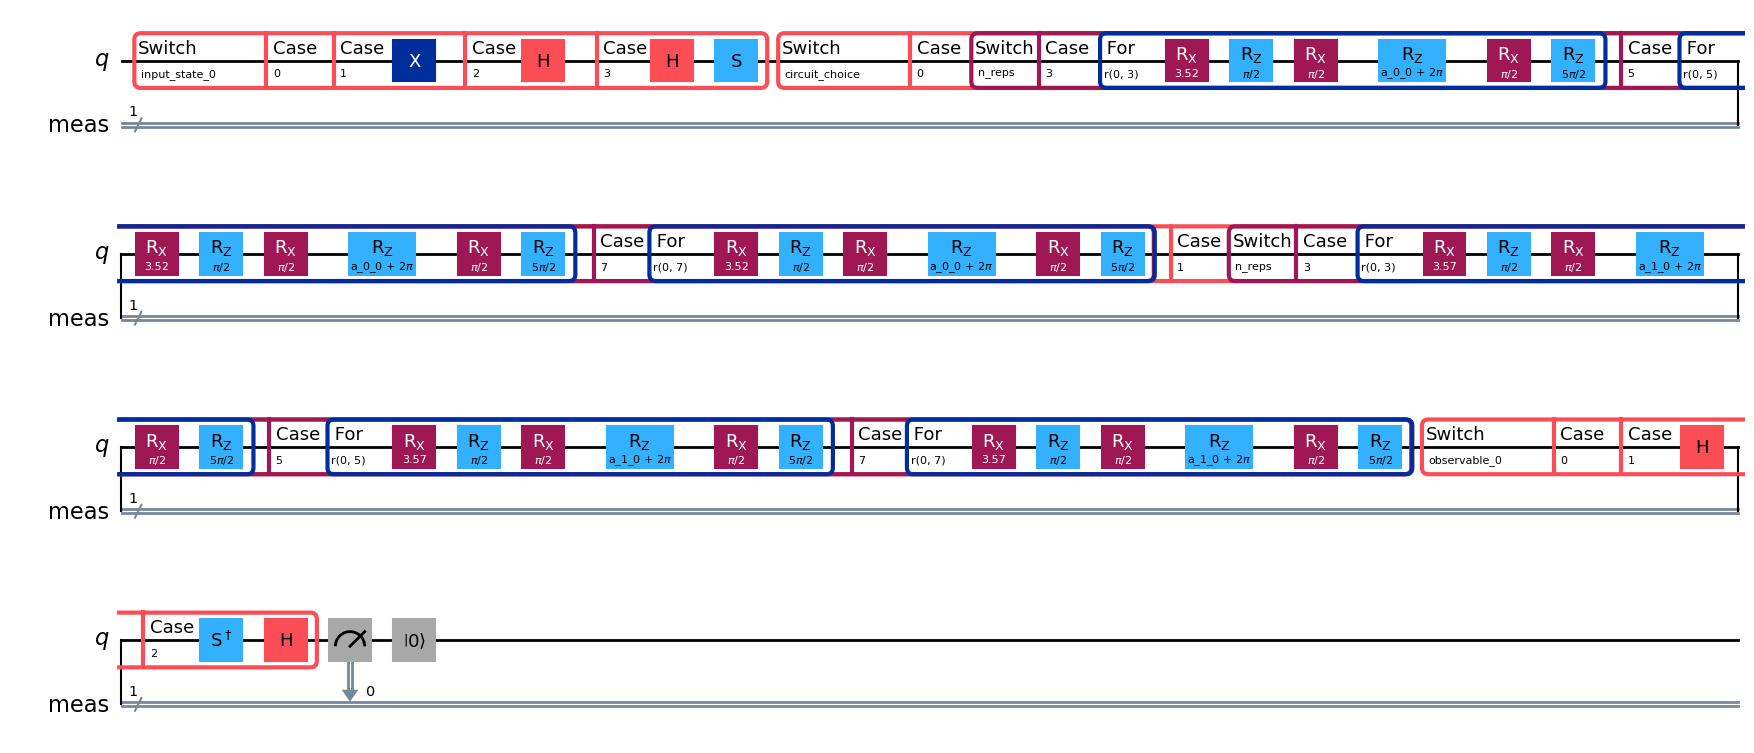

In [23]:
real_time_circ.draw("mpl")

In [18]:
from qiskit.qasm3 import dumps as qasm_dumps

print(qasm_dumps(real_time_circ))

OPENQASM 3.0;
include "stdgates.inc";
input float[64] a_0_0;
input float[64] a_1_0;
input uint[8] n_reps;
input uint[4] observable_0;
input uint[8] circuit_choice;
input uint[4] input_state_0;
bit[1] meas;
int switch_dummy;
int switch_dummy_0;
int switch_dummy_1;
int switch_dummy_2;
int switch_dummy_3;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
  }
  case 1 {
    x $0;
  }
  case 2 {
    h $0;
  }
  case 3 {
    h $0;
    s $0;
  }
}
switch_dummy_0 = circuit_choice;
switch (switch_dummy_0) {
  case 0 {
    switch_dummy_1 = n_reps;
    switch (switch_dummy_1) {
      case 3 {
        for _ in [0:2] {
          rx(3.516949007269292) $0;
          rz(pi/2) $0;
          rx(pi/2) $0;
          rz(a_0_0 + 2*pi) $0;
          rx(pi/2) $0;
          rz(5*pi/2) $0;
        }
      }
      case 5 {
        for _ in [0:4] {
          rx(3.516949007269292) $0;
          rz(pi/2) $0;
          rx(pi/2) $0;
          rz(a_0_0 + 2*pi) $0;
          rx(pi/2) $0;
          rz(5*p

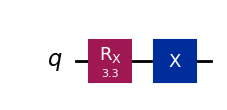

In [20]:
q_env.baseline_circuits[0].draw("mpl")

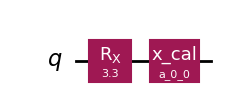

In [21]:
q_env.circuits[0].draw("mpl")

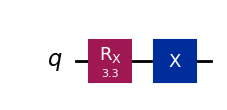

In [22]:
q_env.circuits[0].metadata["baseline_circuit"].draw("mpl")

In [23]:
q_env.circuits[0].metadata["baseline_circuit"].name

'baseline_circ_0'

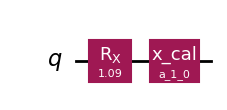

In [24]:
q_env.circuits[1].draw("mpl")

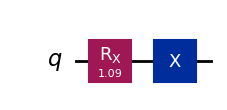

In [25]:
q_env.circuits[1].metadata["baseline_circuit"].draw("mpl")